/workspace/nicky/taker/.venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/tmp/ipykernel_466320/2445770163.py:61: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(data=df, inner="box", cut=0,


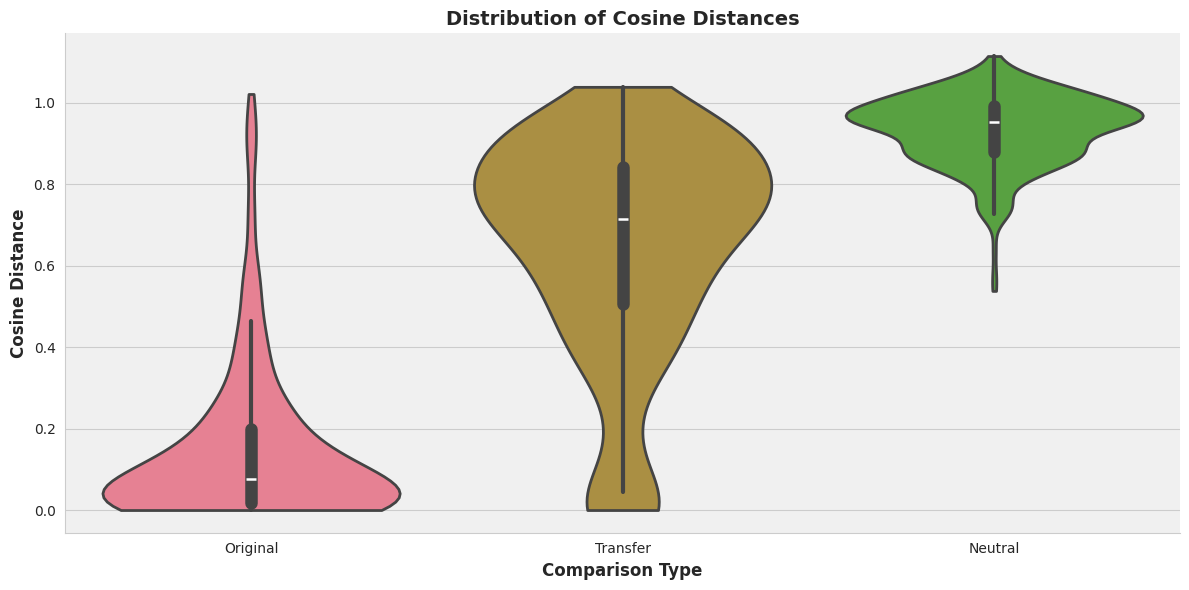

count    3.000000e+02
mean     1.452460e-01
std      1.953436e-01
min     -1.192093e-07
25%      1.614368e-02
50%      7.710534e-02
75%      1.977683e-01
max      1.021165e+00
Name: Original, dtype: float64
count    300.000000
mean       0.642065
std        0.277057
min        0.000000
25%        0.505287
50%        0.714999
75%        0.840913
max        1.038670
Name: Transfer, dtype: float64
count    300.000000
mean       0.932751
std        0.086509
min        0.537807
25%        0.878818
50%        0.952479
75%        0.992035
max        1.114302
Name: Neutral, dtype: float64


In [4]:
import torch
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import json
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import json
import torch


# Initialize SentenceTransformer
sentenceTransformer = SentenceTransformer("all-mpnet-base-v2")

# load jsonl
with open("./results/latest_phi3_generations_gemma2-9b_{tokens_to_transfer}t_x3.jsonl", "r") as file:
    data = [json.loads(line) for line in file]


for prompt_data in data:
    # Embed the generated text
    prompt_data["emb_new"] = sentenceTransformer.encode(prompt_data['new'], convert_to_tensor=True)
    prompt_data["emb_orig"] = sentenceTransformer.encode(prompt_data['orig'], convert_to_tensor=True)
    prompt_data["emb_neutral"] = sentenceTransformer.encode(prompt_data['neutral'], convert_to_tensor=True)

# split into chunks of 3
chunks = [data[i:i+3] for i in range(0, len(data), 3)]


distances = {
    "Original": [],
    "Transfer": [],
    "Neutral": [],
}

# for old, new, neutral in zip(embeds_orig, embeds_new, embeds_neutral):
for chunk in chunks:
    # compare cossim of all three emb_orig
    for i in range(3):
        for j in range(i+1, 3):
            # get cosine similarity
            cosine_similarity = torch.nn.functional.cosine_similarity(chunk[i]['emb_orig'], chunk[j]['emb_orig'], dim=0)
            distances["Original"].append(1-cosine_similarity.item())
        # for j in range(i, 3):
            cosine_similarity = torch.nn.functional.cosine_similarity(chunk[i]['emb_orig'], chunk[j]['emb_new'], dim=0)
            distances["Transfer"].append(1-cosine_similarity.item())
            cosine_similarity = torch.nn.functional.cosine_similarity(chunk[i]['emb_orig'], chunk[j]['emb_neutral'], dim=0)
            distances["Neutral"].append(1-cosine_similarity.item())

# Convert to DataFrame
df = pd.DataFrame(distances, columns=['Original', 'Transfer', 'Neutral'])

# Set up the plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.set_palette("husl")

# Create the violin plot
ax = sns.violinplot(data=df, inner="box", cut=0,
                    linewidth=2, width=0.8, scale="width", order=[
                        "Original",
                        "Transfer",
                        "Neutral"
                    ])

# Customize the plot
plt.xlabel('Comparison Type', fontsize=12, fontweight='bold')
plt.ylabel('Cosine Distance', fontsize=12, fontweight='bold')
plt.title('Distribution of Cosine Distances', fontsize=14, fontweight='bold')

# Adjust tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a subtle background color
ax.set_facecolor('#f0f0f0')

# Remove top and right spines
sns.despine()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# print summary statistics from df
for i in range(3):
    print(df[df.columns[i]].describe())